In [167]:
# SET EXPERIMENT NAME
# Options:
#  - lp (Limit point, scalar system)
#  - pf (Pitchfork, scalar system)
#  - tc (Transcritical, scalar system)
#  - l96 (Hopf, Lorenz96)
#  - nf (Hopf, neural field)

args = Dict()
args["ExpName"] = "nf" # Experiment name, CRITICAL PARAMETER
args["DataDir"] = "/home/manu/Documents/Work/NormalFormAEData"
args["Dir"] = "/home/manu/Documents/Work/NormalFormAE"

ENV["JULIA_CUDA_VERBOSE"] = true
ENV["JULIA_CUDA_MEMORY_POOL"] = "split" # Efficient allocation to GPU (Julia garbage collection is inefficient for this code apparently)
ENV["JULIA_CUDA_MEMORY_LIMIT"] = 8000_000_000

import Pkg
Pkg.activate("$(args["Dir"])")
using NormalFormAE
using Zygote
using Plots, Flux, LaTeXStrings
using BSON, JLD2

include("$(args["Dir"])/src/problems/$(args["ExpName"]).jl")
include("$(args["Dir"])/run/run_$(args["ExpName"]).jl")

 Activating environment at `~/Documents/Work/NormalFormAE/Project.toml`


0.1f0

# Get data and NNs

In [168]:
load_flag = 0 # 0: load data, 1: create data
train_flag = 0 # 0: no training, 1: train over data

0

In [169]:
if load_flag == 0 # Load data
    args, NN, training_data, test_data = load_posttrain(args) # Needs ExpName and DataDir
    args["pre_train"] = false
else
    NN = gen_NN(args)
    training_data, test_data = gen_train_test(args,dxdt_rhs,dxdt_sens_rhs)
    args["pre_train"] = true
end


args were not saved


false

In [165]:
NN["tscale"] = [1.0009] |> gpu
using FileIO
tscale = cpu(NN["tscale"])
FileIO.save("$(args["DataDir"])/Final/$(args["ExpName"])/tscale.jld2","tscale",tscale)

# Training

In [170]:
if train_flag == 0 # Load data and plotter
    trained_NN = (NN["encoder"],NN["decoder"],NN["par_encoder"],NN["par_decoder"])
    args["nEpochs"] = 0
    plot_, enssol = train(args,training_data,test_data,NN,trained_NN,dzdt_rhs,dzdt_solve,dzdt_sens_rhs) 
else # train
    trained_NN = (NN["encoder"],NN["decoder"],NN["par_encoder"],NN["par_decoder"])
    plot_, enssol = train(args,training_data,test_data,NN,trained_NN,dzdt_rhs,dzdt_solve,dzdt_sens_rhs)
    save_posttrain(args,NN,training_data,test_data)
end

(Any[Plot{Plots.GRBackend() n=0}, Plot{Plots.GRBackend() n=0}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=0}], NormalFormAE.var"#enssol#29"{NormalFormAE.var"#enssol#14#30"{typeof(dzdt_solve)}}(NormalFormAE.var"#enssol#14#30"{typeof(dzdt_solve)}(dzdt_solve)))

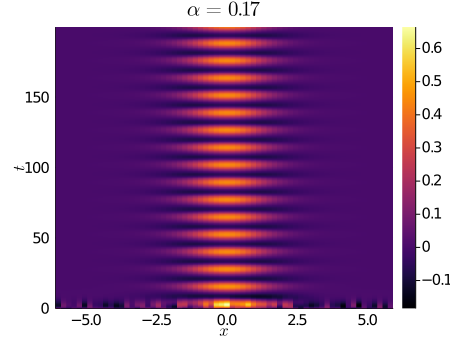

In [188]:
# Visualize training data (PDEs)
tt = Array(0:args["tspan"][2]/(args["tsize"]):args["tspan"][2])[1:end-1]
ind = 11 # Max test size
par_ = round(test_data["alpha"][1,ind],digits=2)
heatmap(x,tt,test_data["x"][1:64,args["tsize"]*(ind-1)+1:args["tsize"]*(ind)]'.+y0[1:64,:]',
    font=font(10),xlabel=latexstring("x"),ylabel=latexstring("t"),
    title=latexstring("\\alpha = $(par_)"),size=(450,350),xtickfont=font(10),ytickfont=font(10))



# Post-train plotting

1. Parameters and set up

In [171]:
encoder = NN["encoder"]
par_encoder = NN["par_encoder"]
x_test = test_data["x"]
par_encoder = NN["par_encoder"];
args["nPlots"] = 10
args["EnsPlots"] = 30
args["VarPlot"] = 0.1f0

lower,upper,sol=enssol(args,args["EnsPlots"],cpu(NN["encoder"](gpu(test_data["x"]))),
        cpu(NN["par_encoder"](gpu(test_data["alpha"]))),tscale=NN["tscale"])

([-0.031712186056832514 -0.0056400710759076265 … 3.1000075391126184e-7 1.3890036346000377e-7; -0.13008048545452044 -0.12559261929354396 … 1.957380950181626e-7 3.2239896811830143e-7], [0.05835247515031432 0.07852333600335229 … 8.458120518239456e-7 6.701128571554097e-7; -0.03384765493939908 -0.018509244624470896 … 7.572017143030915e-7 8.679819284278481e-7], [0.05141791186705179 0.07852333600335229 … 5.095129321003379e-7 3.5485055068680964e-7; -0.12220252617293985 -0.09790516115032527 … 3.5736803419761167e-7 4.91523664410893e-7])

2. Plot simulated and learned dynamics all together

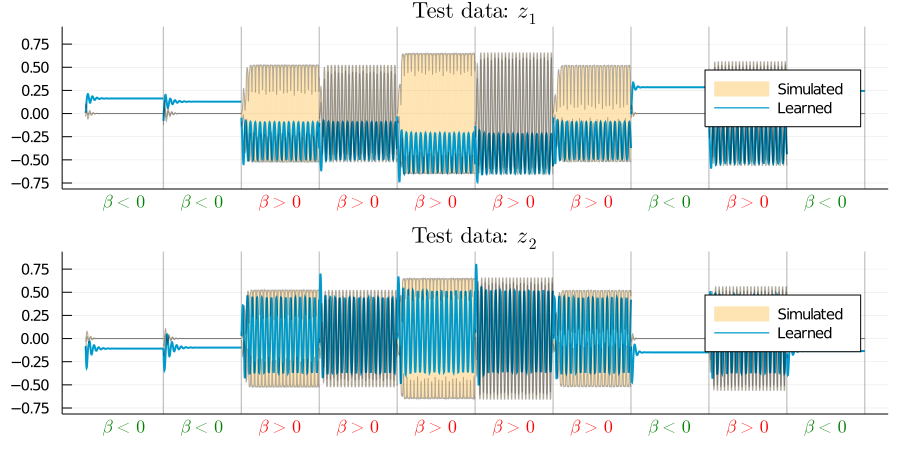

In [173]:
p = []
using Measures
Plots.closeall()
for i in 1:args["z_dim"]
    p_ = plot()
    lab_ = []
    for j in 1:args["nPlots"]
        ind_ = args["tsize"]*(j-1)+1:(args["tsize"]*j)
        plot!(ind_,[sol[i,ind_] sol[i,ind_]], fillrange= [lower[i,ind_] upper[i,ind_]],linealpha=0,
            fillalpha = 0.3, c=:orange,legend=:right,legendfontsize=10,lab="",xtick=[],bottom_margin = 5mm,
            ylims = (1.1*minimum([encoder(gpu(x_test)) upper]),1.1*maximum([encoder(gpu(x_test)) upper])))
        plot!(ind_,encoder(gpu(x_test))[i,ind_],
            title=latexstring("\\textrm{Test data: } z_$(i)"),lab="",linewidth=2,titlefont=font(15),size=(900,450),
            c=:deepskyblue3,xtickfont = font(15),ytickfont = font(10))
        plot!(ind_,upper[i,ind_],c=:black,lab="",linealpha=0.3)
        plot!(ind_,lower[i,ind_],c=:black,lab="",linealpha=0.3)
        vline!(Array(ind_)[end:end],line = (:black, 0.3),lab = "")
        par_enc = cpu(par_encoder(gpu(test_data["alpha"]))[1,j])
        par_ = test_data["alpha"][1,j]
#         if sign(par_) == sign(par_enc)
#             col_ = :green
#         else
#             col_ = :red
#         end
        if sign(par_)<0
            str_ = latexstring("\\beta < 0")
            col_ = :green
        else
            str_ = latexstring("\\beta > 0")
            col_ = :red
        end
        push!(lab_,str_)
        annotate!(ind_[Int(end/2)],1.3*minimum(encoder(gpu(x_test))),text(str_,
                col_, :center, 12))
    end
    plot!([0],fillrange=[1 1],c=:orange,fillalpha=0.3,linealpha=0,label="Simulated")
    plot!([],c=:deepskyblue3,label="Learned")
    push!(p,p_)
end
display(plot(p...,layout=(args["z_dim"],1)))

3. Plot one example of simulated and learned dynamics

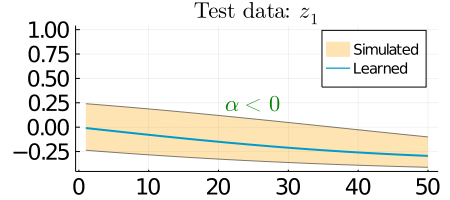

In [119]:
ind = 10 # max args["test_size"]
p = []

for i in 1:args["z_dim"]
    p_ = plot()
    j = ind
    ind_ = args["tsize"]*(j-1)+1:(args["tsize"]*j)
    plot!([sol[i,ind_] sol[i,ind_]], fillrange= [lower[i,ind_] upper[i,ind_]],linealpha=0,
        fillalpha = 0.3, c=:orange,legend=:topright,legendfontsize=10,lab="")
    plot!(encoder(gpu(x_test))[i,ind_],
        title=latexstring("\\textrm{Test data: } z_$(i)"),lab="",linewidth=2,titlefont=font(15),size=(450,200),
        c=:deepskyblue3,xtickfont = font(15),ytickfont = font(15))
    plot!(upper[i,ind_],c=:black,lab="",linealpha=0.5)
    plot!(lower[i,ind_],c=:black,lab="",linealpha=0.5)
    plot!([0],fillrange=[1 1],c=:orange,fillalpha=0.3,linealpha=0,label="Simulated")
    plot!([],c=:deepskyblue3,label="Learned")
    par_enc = cpu(par_encoder(gpu(test_data["alpha"]))[1,j])
        par_ = test_data["alpha"][1,j]
        if sign(par_) == sign(par_enc)
            col_ = :green
        else
            col_ = :red
        end
        if sign(par_)<0
            str_ = latexstring("\\alpha < 0")
        else
            str_ = latexstring("\\alpha > 0")
        end
    annotate!(args["tsize"]/2,maximum(upper[i,ind_]),text(str_,
                col_, :center, 15))
    push!(p,p_)
end
display(plot(p...,layout=(1,args["z_dim"])))

4. Plot parameters

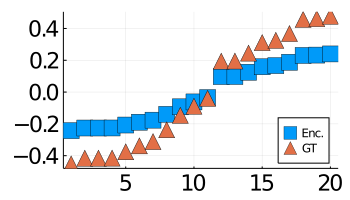

In [64]:
alpha_test = sort(test_data["alpha"],dims=2)
scatter(par_encoder(gpu(alpha_test))',markershape=:rect,markersize=8,
    xtickfont = font(15),ytickfont = font(15),size=(350,200),lab="Enc.",legend=:bottomright)
scatter!(alpha_test',markershape=:utriangle,markersize=8,lab="GT")




In [131]:
NN["tscale"]

1-element CuArrays.CuArray{Float32,1,Nothing}:
 1.0